### 1. Outline a training routine for a neural network.

**Neural Networks**

Neural networks are a class of models that are built with layers. Commonly used types of neural networks include convolutional and recurrent neural networks.

**A Deep Neural Network Model**

To build a classification model for a classification model, we can have a look at a neural network example with four neurons in an input layer, two hidden layers, and three neurons in an output layer.

![Neural networks architecture](images/deep-neural-network.png)

The deep neural network model for the classifier consists of multiple layers of artificial neurons. In this case, there are four layers:

* An input layer with a neuron for each expected input (x) value.
* Two so-called hidden layers, each containing five neurons.
* An output layer containing three neurons - one for each class probability (y) value to be predicted by the model.

**Convolutional Neural Networks**

While one can use deep learning models for any kind of machine learning, they're particularly useful for dealing with data that consists of large arrays of numeric values - such as images. Machine learning models that work with images are the foundation for an area artificial intelligence called computer vision, and deep learning techniques have been responsible for driving amazing advances in this area over recent years.

At the heart of deep learning's success in this area is a kind of model called a convolutional neural network, or CNN. A CNN typically works by extracting features from images, and then feeding those features into a fully connected neural network to generate a prediction. The feature extraction layers in the network have the effect of reducing the number of features from the potentially huge array of individual pixel values to a smaller feature set that supports label prediction.

![Basic CNN architecture](images/convolutional-neural-network.png)

* Images are fed into a convolutional layer. In this case, there are two filters, so each image produces two feature maps.
* The feature maps are passed to a pooling layer, where a 2x2 pooling kernel reduces the size of the feature maps.
* A dropping layer randomly drops some of the feature maps to help prevent overfitting.
* A flattening layer takes the remaining feature map arrays and flattens them into a vector.
* The vector elements are fed into a fully connected network, which generates the predictions. In this case, the network is a classification model that predicts probabilities for three possible image classes (triangle, square, and circle).

**Train a Convolutional Neural Network**

A convolutional neural network is a kind of neural network that extracts features from matrices of numeric values (often images) by convolving multiple filters over the matrix values to apply weights and identify patterns, such as edges, corners, and so on in an image. The numeric representations of these patterns are then passed to a fully-connected neural network layer to map the features to specific classes.

**Connect GitHub to Google Colab**

First we are going to connect GitHub repository in order to work under Google Colab environment.

In [ ]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
# copy the content of repository
github_path = Path('/content/VLC/')

#if github_path.is_file():
#    # file exists

'''
!rm -r '/content/VLC'
!git clone https://github.com/epilicer/VLC.git
'''

if github_path.is_dir():
  os.chdir(github_path)
  !git pull
  os.chdir('..')
else:
  !git clone https://github.com/epilicer/VLC.git

Cloning into 'VLC'...
remote: Enumerating objects: 1218, done.
remote: Counting objects: 100% (1218/1218), done.
remote: Compressing objects: 100% (746/746), done.
remote: Total 1218 (delta 468), reused 1218 (delta 468), pack-reused 0
Receiving objects: 100% (1218/1218), 7.23 MiB | 20.86 MiB/s, done.
Resolving deltas: 100% (468/468), done.


In [ ]:
!pip install -q torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

print('Libraries imported - ready to use PyTorch', torch.__version__)

Libraries imported - ready to use PyTorch 1.9.0+cpu


**Explore The Data**

Here we are going to train a CNN-based classification model that can classify images of geometric shapes. Let's take a look at the classes of shape the model needs to identify.

3 classes:
['circle', 'square', 'triangle']


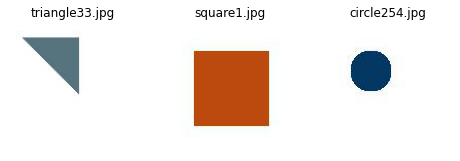

In [ ]:
# The images are in the data/shapes folder
data_path = '/content/VLC/data/shapes'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

**Load Data**

PyTorch includes functions for loading and transforming data. We'll use these to create an iterative loader for training data, and a second iterative loader for test data (which we'll use to validate the trained model). The loaders will transform the image data into tensors, which are the core data structure used in PyTorch, and normalize them so that the pixel values are in a scale with a mean of 0.5 and a standard deviation of 0.5.

In [ ]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

Data loaders ready


**Define the CNN**

In PyTorch, one define a neural network model as a class that is derived from the nn.Module base class. Your class must define the layers in your network, and provide a forward method that is used to process data through the layers of the network.

In [ ]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A second convolutional layer takes 12 input channels, and generates 12 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A third convolutional layer takes 12 inputs and generates 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # So our feature tensors are now 32 x 32, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool(self.conv2(x)))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv3(x)))
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return log_softmax tensor 
        return F.log_softmax(x, dim=1)

print('CNN model class defined!')

CNN model class defined!


**Train The Model**

The class for the network have been defined, now we can train it using the image data.

Training consists of an iterative series of forward passes in which the training data is processed in batches by the layers in the network, and the optimizer goes back and adjusts the weights. A set of test images will be used separately to test the model at the end of each iteration (or epoch) so the performance improvement can be tracked as the training process progresses.

5 epochs is used to train the model using the batches of images loaded by the data loaders, holding back the data in the test data loader for validation. After each epoch, a loss function measures the error (loss) in the model and adjusts the weights (which were randomly generated for the first iteration) to try to improve accuracy.

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
  # Set the model to training mode
  model.train()
  train_loss = 0
  print("Epoch:", epoch)
  # Process the images in batches
  for batch_idx, (data, target) in enumerate(train_loader):
    # Use the CPU or GPU as appropriate
    data, target = data.to(device), target.to(device)
    
    # Reset the optimizer
    optimizer.zero_grad()
    
    # Push the data forward through the model layers
    output = model(data)
    
    # Get the loss
    loss = loss_criteria(output, target)
    
    # Keep a running total
    train_loss += loss.item()
    
    # Backpropagate
    loss.backward()
    optimizer.step()
    
    # Print metrics for every 10 batches so we see some progress
    if batch_idx % 10 == 0:
        print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
            batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          
  # return average loss for the epoch
  avg_loss = train_loss / (batch_idx+1)
  print('Training set: Average loss: {:.6f}'.format(avg_loss))
  return avg_loss
          
            
def test(model, device, test_loader):
  # Switch the model to evaluation mode (so we don't backpropagate or drop)
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      batch_count = 0
      for data, target in test_loader:
          batch_count += 1
          data, target = data.to(device), target.to(device)
          
          # Get the predicted classes for this batch
          output = model(data)
          
          # Calculate the loss for this batch
          test_loss += loss_criteria(output, target).item()
          
          # Calculate the accuracy for this batch
          _, predicted = torch.max(output.data, 1)
          correct += torch.sum(target==predicted).item()

  # Calculate the average loss and total accuracy for this epoch
  avg_loss = test_loss/batch_count
  print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      avg_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  
  # return average loss for the epoch
  return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs (in a real scenario, you'd likely use many more)
epochs = 5
for epoch in range(1, epochs + 1):
  train_loss = train(model, device, train_loader, optimizer, epoch)
  test_loss = test(model, device, test_loader)
  epoch_nums.append(epoch)
  training_loss.append(train_loss)
  validation_loss.append(test_loss)

Training on cpu
Epoch: 1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training set [0/840 (0%)] Loss: 1.111113
Training set [500/840 (59%)] Loss: 0.933669
Training set: Average loss: 0.995748
Validation set: Average loss: 0.709065, Accuracy: 251/360 (70%)

Epoch: 2
Training set [0/840 (0%)] Loss: 0.627866
Training set [500/840 (59%)] Loss: 0.313270
Training set: Average loss: 0.453706
Validation set: Average loss: 0.338437, Accuracy: 306/360 (85%)

Epoch: 3
Training set [0/840 (0%)] Loss: 0.323224
Training set [500/840 (59%)] Loss: 0.174569
Training set: Average loss: 0.230009
Validation set: Average loss: 0.178892, Accuracy: 345/360 (96%)

Epoch: 4
Training set [0/840 (0%)] Loss: 0.129098
Training set [500/840 (59%)] Loss: 0.062572
Training set: Average loss: 0.114698
Validation set: Average loss: 0.081953, Accuracy: 355/360 (99%)

Epoch: 5
Training set [0/840 (0%)] Loss: 0.084356
Training set [500/840 (59%)] Loss: 0.048970
Training set: Average loss: 0.062228
Validation set: Average loss: 0.045117, Accuracy: 353/360 (98%)



**View The Loss History**

The average training and validation loss for each epoch were tracked. One can plot these to verify that loss reduced as the model was trained, and to detect over-fitting (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase).

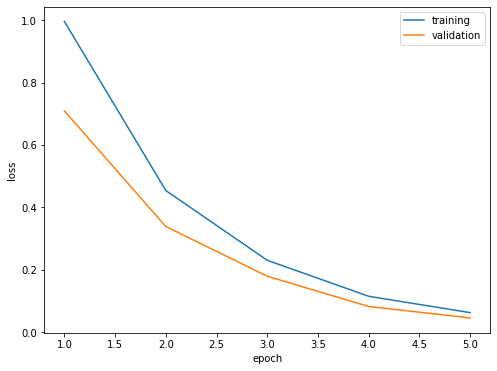

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

**Evaluate Model Performance**

The final accuracy based on the test data can be seen, but typically one wants to explore performance metrics in a little more depth. Let's plot a confusion matrix to see how well the model is predicting each class.



Getting predictions from test set...


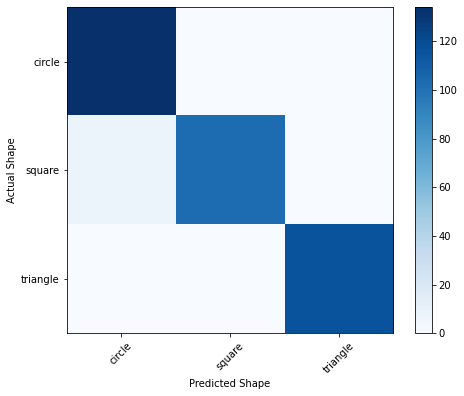

In [ ]:
# Pytorch doesn't have a built-in confusion matrix metric, 
# so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays 
# for use with SciKit-Learn
print('Getting predictions from test set...')
truelabels = []
predictions = []
for data, target in test_loader:
  for label in target.cpu().data.numpy():
    truelabels.append(label)
  for prediction in model.cpu()(data).data.numpy().argmax(1):
    predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Shape')
plt.ylabel('Actual Shape')
plt.show()

In [ ]:
# Save the model weights
model_file = '/content/VLC/models/shape_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as /content/VLC/models/shape_classifier.pt


**Use The Trained Model**

Now the model have been trained and evaluated, it can be used to predict classes for new images.

triangle


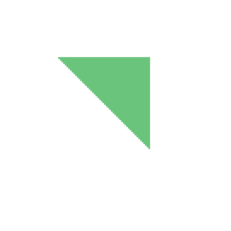

In [ ]:
from random import randint
from PIL import Image, ImageDraw

# Function to predict the class of an image
def predict_image(classifier, image):    
  # Set the classifer model to evaluation mode
  classifier.eval()
  
  # Apply the same transformations as we did for the training images
  transformation = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
  ])

  # Preprocess the image
  image_tensor = transformation(image).float()

  # Add an extra batch dimension since pytorch treats all inputs as batches
  image_tensor = image_tensor.unsqueeze_(0)

  # Turn the input into a Variable
  input_features = Variable(image_tensor)

  # Predict the class of the image
  output = classifier(input_features)
  index = output.data.numpy().argmax()
  return index


# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):   
  xy1 = randint(10,40)
  xy2 = randint(60,100)
  col = (randint(0,200), randint(0,200), randint(0,200))

  img = Image.new('RGB', size, (255, 255, 255))
  draw = ImageDraw.Draw(img)
  
  if shape == 'circle':
      draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
  elif shape == 'triangle':
      draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
  else: # square
      draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
  del draw
  
  return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('/content','VLC','data', 'shapes'))
classnames.sort()
shape = classnames[randint(0, len(classnames)-1)]
img = create_image ((128,128), shape)

# Display the image
plt.axis('off')
plt.imshow(img)

# Create a new model class and load the saved weights
model = Net()
model.load_state_dict(torch.load(model_file))

# Call the predction function
index = predict_image(model, img)
print(classes[index])

**An Example of Training Routine For a Neural Network**

Here is an example of a training routine for a neural network:

```
# Define the neural network architecture
initialize_network()

# Set the initial values for the network weights
initialize_weights()

# Define the loss function
define_loss_function()

# Define the optimizer
define_optimizer()

# Set the number of training iterations (epochs)
set_number_of_epochs(n)

# Loop through the number of training iterations (epochs)
for i in range(n):

  # Loop through the training dataset
  for input, target in training_dataset:
    
    # Forward pass: Compute the predicted output
    output = forward_pass(input)
    
    # Compute the loss
    loss = loss_function(output, target)
    
    # Backward pass: Compute the gradients
    compute_gradients(loss)
    
    # Update the weights
    update_weights(optimizer)
    
    # Periodically check the validation error
    if i % check_interval == 0:
      validation_error = compute_validation_error()
      
      # Save the best model
      if validation_error < best_error:
        best_error = validation_error
        save_best_model()

# Load the best model
load_best_model()
```

### 2. Suppose that you have collected data on the growth rate of cancer cells and built a statistical model that fits your acquired data well. What general strategies exist to test your model?

The crucial part of creating a good model working effectively on the test data is to have large, diverse and cleaned data to train the model. While training the model, the data should be splitted into three parts, training, testing and validation. The evaluation of the model should use the training data, while verification of the model would use about 25% of the entire data. Typical results from this stage of verification can be seen below as the "test error" line, and notice how they always have a higher error rate than "training error" data.

![Training error line](images/error-loss-training-cyyles-epoches.png)

On top of this, the general strategies for testing a statistical model could be:

* Holdout method: This involves randomly dividing the dataset into a training set and a test set, fitting the model on the training set, and evaluating its performance on the test set.

* k-fold cross-validation: This method involves randomly dividing the dataset into k subsets (folds), fitting the model k times, each time using a different fold as the test set, and averaging the performance across all k iterations.

* Bootstrap: This method involves repeatedly sampling the dataset with replacement, fitting the model on each sample, and measuring the variability of the model's performance across the samples.

* Simulation: Simulate the data generation process assuming the model is true, by generating data from estimated parameters, then, compare the generated data with the original.

* External validation: It is also known as Out-of-sample testing. This involves testing the model on a separate dataset that was not used in the model building process. This can provide insight into the generalizability of the model to new data.

* Sensitivity Analysis: This involves testing the model with small variations in the data or the parameters of the model, to test how robust the model is to changes.

* Model Comparison: This involves comparing the performance of the model with other models, to check which model works best for the data.


### 3. A colleague asks you to make their deep learning model written in Python available to (1) Other peers in the lab and (2) the entire research community.

### 3-a. Which technologies do you recommend to the colleague? 

There are many technologies available for training deep neural networks, the most popular deep learning model written in Python:

* Python packages: Python packages such as [TensorFlow](https://www.tensorflow.org), [PyTorch](https://pytorch.org), and [Keras](https://keras.io/) can be used to create and train their deep learning model, and then to make the trained model available as a package so that they can be easily installed and used by others.

* Cloud-based services: Cloud-based services such as AWS SageMaker, Google Cloud AI Platform, or Microsoft Azure Machine Learning can be used to train and deploy their deep learning model, thus making it available as a cloud-based API that can be accessed by others.

* Source code and model files: The source code of their deep learning model can be available on a version control platform such as GitHub, along with the trained model files, so others can use, train and test their model.

* Docker: A Docker container can be used to hold deep learning models, which makes it easy to distribute and run the model in a reproducible environment. Docker images can be uploaded to a public or private registry, like Docker hub, for others to download and run.

* Model serving platforms: Platforms like TensorFlow serving, Open Neural Network Exchange (ONNX-Runtime), MLFlow, Clipper and Seldon can be used. They are are specifically designed to serve deep learning model over the internet in a production environment.

* Model zoo: A model zoo is a collection of pre-trained models that can be easily used, customized and fine-tuned. Popular model zoos include the TensorFlow Hub and the PyTorch Hub.

### 3-b. What solutions exist to ensure that the code is executable and yields reproducible results? 

To ensure that a deep learning model written in Python is executable and yields reproducible results, some of the followings could be solutions:

* Containerization: Using a containerization technology such as Docker can help to ensure that the code is executable in a consistent environment, regardless of the underlying infrastructure. It also allows for easy sharing and deployment of the model.

* Version control: Using a version control system such as Git to manage the codebase can help to keep track of changes, roll back to previous versions if necessary, and collaborate with others.

* Environment management: Using a package and environment management tools such as conda or virtualenv to manage dependencies, ensures that the code is executable and the environment is consistent, regardless of the underlying infrastructure.

* Cloud-based services: Cloud-based services such as AWS or GCP, which can automate the management of the underlying infrastructure, which allows the other researchers to run and reproduce the model, with minimal effort.

* Reproducible tools: Using tools and frameworks such as Jupyter Notebook, Google Colab, to document the research process and the steps that were taken to train the model, which can make it easier for others to understand and reproduce the work.

* Documentation: Good documentation of the model and its dependencies, as well as instructions on how to run the code, will make it easier for others to understand, execute, and reproduce the results.

It's important to note that reproducibility is an ongoing process and it's essential to regularly check and test the model in different environments to ensure that it's still working as expected. 

The up-to-date neural network models found in the literature have been listed based on the accuracy results ranking.

* SpectralNET: Exploring Spatial-Spectral WaveletCNN for Hyperspectral Image Classification

* FSKNet: Faster hyperspectral image classification based on selective kernel mechanism using deep convolutional networks

* HybridSN: Exploring 3D-2D CNN Feature Hierarchy for Hyperspectral Image Classification

* JigsawHSI: a network for Hyperspectral Image classification

* SSDGL: A Spectral-Spatial-Dependent Global Learning Framework for Insufficient and Imbalanced Hyperspectral Image Classification

* A2S2K-ResNet (Attention-Based Adaptive Spectral-Spatial Kernel ResNet): Attention-Based Adaptive Spectral-Spatial Kernel ResNet for Hyperspectral Image Classification

* Recurrent 3D-CNN: Hyperspectral Image Classification with Deep Metric Learning and Conditional Random Field

* A-SPN (Attention-Based Second-Order Pooling Network): Attention-Based Second-Order Pooling Network for Hyperspectral Image Classification

* CVSSN (Central Vector oriented Self-Similarity Network): Exploring the Relationship between Center and Neighborhoods Central Vector oriented Self-Similarity Network for Hyperspectral Image Classification

* BASSNet (Band-Adaptive Spectral-Spatial Feature Learning Neural Network): Band-Adaptive Spectral-Spatial Feature Learning Neural Network for Hyperspectral Image Classification

* CNN-MRF: Hyperspectral Image Classification with Markov Random Fields and a Convolutional Neural Network

* St-SS-pGRU: Shorten Spatial-spectral RNN with Parallel-GRU for Hyperspectral Image Classification

### 3-c. What special considerations have to be made before sharing outside of the lab?

Before sharing the results outside of the lab, the outcome must be validated with high accuracy on the diverse data and also set of boundaries in order to eliminate the model just performing a guess.

Some of the special considerations that should be made:

* Legal and ethical considerations: Deep learning models can be used to make decisions that affect people's lives, so it's important to consider the legal and ethical implications of using the model and sharing it with others. This includes ensuring that the model is not biased against certain groups of people and that it is not being used for any illegal or unethical purposes.

* Privacy and security: If the model is being used with sensitive data, it's important to ensure that the data is protected and not shared with unauthorized parties. This includes implementing security measures such as encryption, access controls, and logging to track who is using the model and for what purpose.

* Data availability and quality: The model should be trained and evaluated with a good representative dataset that is large enough and diverse enough. Also, any dataset used to train the model should be easily accessible and well-documented so that others can understand the data source and its representativeness.

* Licensing and distribution: It is important to consider how the model will be distributed and what kind of license will be used. This includes ensuring that the terms of the license allow others to use, modify, and distribute the model, and that any third-party libraries or datasets used in the model are also properly licensed.

* Support and maintenance: As the model is shared with a wider community, it is important to consider the resources required to provide adequate support and maintenance. This may include updating the model to reflect new developments in the field, addressing bugs or issues that arise, and providing documentation and tutorials to help others use the model effectively.


### 4. Suppose that you are given hyperspectral imaging data from an experiment (here represented by the Indian Pines data set from http://lesun.weebly.com/hyperspectral-data-set.html [Download for the data file]. Answer the following questions by writing Python code.

### 4-a. Automatically download the .MAT file from the link (but only if it wasn’t downloaded already) and load it into memory.

In [ ]:
from pathlib import Path
import os

# copy the content of repository
github_path = Path('/content/VLC/')

if github_path.is_dir():
  os.chdir(github_path)
  !git pull
  os.chdir('..')
else:
  !git clone https://github.com/epilicer/VLC.git

data_file = Path('/content/VLC/data/Indian_pines_corrected.mat')

if data_file.is_file():
  print('Data file exists!')
else:
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat

Already up to date.
Data file exists!


### 4-b. Save .txt file on the hard drive named "dataset_description.txt", in which you report descriptive statistics for each of the spectral reflectance bands of the contents of the MAT file.

In [ ]:
from scipy.io import loadmat

mat_contents = loadmat(str(data_file))
sorted(mat_contents .keys())

['__globals__', '__header__', '__version__', 'indian_pines_corrected']

In [ ]:
data_set = mat_contents['indian_pines_corrected']

In [ ]:
from scipy import stats

def descriptive_statistics(data):
  return stats.describe(data.flatten())

In [ ]:
f = open('descriptive_statistics.txt', 'w')
f.write('Layer Min Max Mean Variance Skewness Kurtosis\n')

for i in range(data_set.shape[2]): # range(10)
  st = descriptive_statistics(data_set[:,:, i])
  f.write('%d %d %d %f %f %f %f \n' % (i, st.minmax[0], st.minmax[1], 
                                     st.mean, st.variance, st.skewness, 
                                     st.kurtosis))

f.close()  

### 4-c. Display the multispectral image at the first, center, and last band.

In [ ]:
def plot_band(data, title):
  plt.figure(figsize=(8, 6))
  plt.imshow(data, cmap='jet')
  plt.title(f'Band-{title}', fontsize=14)
  plt.axis('off')
  plt.colorbar()
  plt.show()

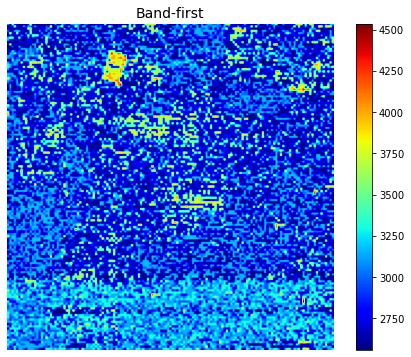

In [ ]:
plot_band(data_set[:,:,0], 'first')

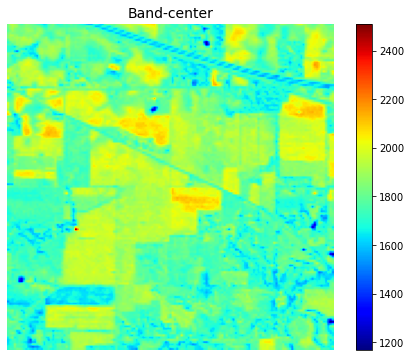

In [ ]:
plot_band(data_set[:,:,data_set.shape[2]//2], 'center')

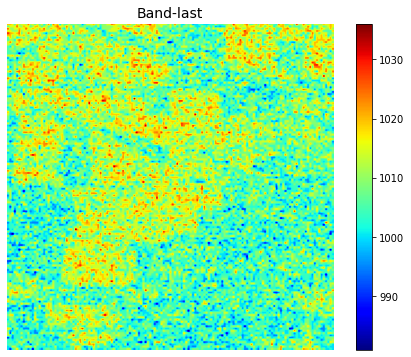

In [ ]:
plot_band(data_set[:,:,-1], 'last')

### 4-d. Perform a principal component analysis of the data and plot (i). a scatter plot with the second versus the third principal component. (ii). An image of the scene colour coded with the magnitude of the first principal component. What does this image show?

In [ ]:
# The ground truth of the dataset in .mat format
from pathlib import Path

data_file = Path('Indian_pines_gt.mat')

if data_file.is_file():
  print('Ground truth data file exists!')
else:
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

--2023-01-11 10:30:21--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat [following]
--2023-01-11 10:30:22--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2023-01-11 10:30:22 (83.8 MB/s) - ‘Indian_pines_gt.mat’ saved [1125/1125]



In [ ]:
ground_truth = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

In [ ]:
def extract_pixels(data, ground_truth):
  df = pd.DataFrame()
  for i in range(data.shape[2]):
    df = pd.concat([df, pd.DataFrame(data[:, :, i].ravel())], axis=1)
  df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
  df.columns = [f'band-{i}' for i in range(1, 1+data.shape[2])]+['class']
  return df

In [ ]:
df = extract_pixels(data_set, ground_truth)
df.head()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
from sklearn.decomposition import PCA
# from sklearn.preprocessing import MinMaxScaler

# Normalize the numeric features so they're on the same scale
# scaled_features = MinMaxScaler().fit_transform(X)

# pca = PCA(n_components = 0.99)
# features = pca.fit_transform(scaled_features)

pca = PCA(n_components = 3)
features = pca.fit_transform(X)

print(X.shape, pca.n_components_)

(21025, 200) 3


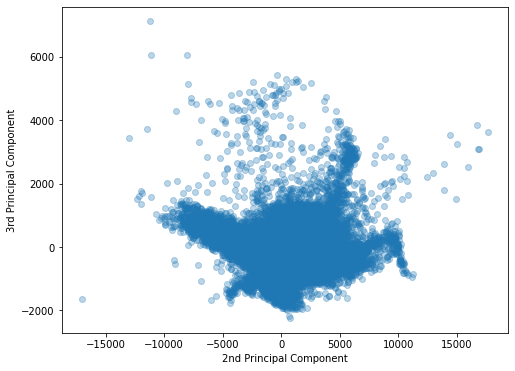

In [ ]:
# scatter plot with the second versus the third principal component
plt.figure(figsize=(8, 6))
plt.scatter(features[:,1], features[:,2], alpha=0.3)
plt.xlabel('2nd Principal Component')
plt.ylabel('3rd Principal Component')
plt.show()

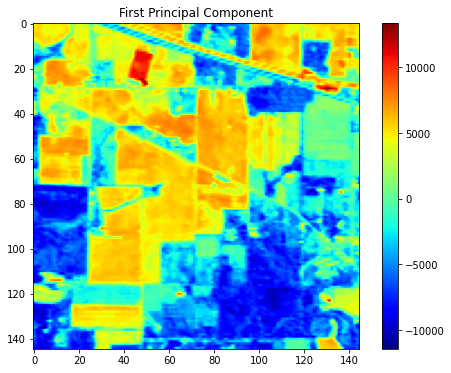

In [ ]:
pca = PCA(n_components = 1)
features = pca.fit_transform(X)

# Plot the image of the scene with color-coded magnitude of the first principal component
plt.figure(figsize=(8, 6))
plt.imshow(features[:, 0].reshape(145,145),  cmap='jet')
plt.colorbar()
plt.title("First Principal Component")
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasturemowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers']


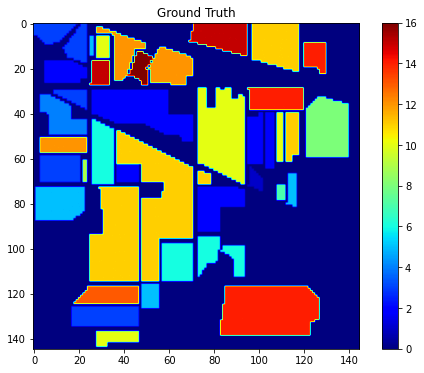

In [ ]:
class_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 
'Grass-trees', 'Grass-pasturemowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 
'Soybean-mintill', 'Soybean-clean','Wheat', 'Woods', 'Buildings-Grass-Trees-Drives', 
'Stone-Steel-Towers']

print(np.unique(y))
print(class_names)

plt.figure(figsize=(8, 6))
plt.imshow(ground_truth, cmap='jet')
plt.colorbar()
plt.title('Ground Truth')
# plt.gca().legend(class_names, loc='upper left')
plt.show()

### 4-e. Perform k-means clustering of the data with k=16 classes and visualise the resulting scene classification. (i). How do the results change if you normalise the input spectra individually to unit norm before performing the clustering? How do you interpret the results?

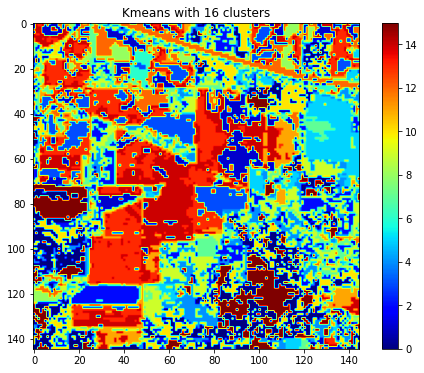

In [ ]:
from sklearn.cluster import KMeans

# Perform k-means clustering
kmeans = KMeans(n_clusters=16)
y_pred = kmeans.fit_predict(X)

#Reshape the label array to match the original size of the image
y_pred = y_pred.reshape(145,145)

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(y_pred, cmap='jet')
plt.title('Kmeans with 16 clusters')
plt.colorbar()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, 
                                                    test_size = 0.25, stratify=y)
print(X_train.shape)
print(X_test.shape)

kmeans = KMeans(n_clusters=16)
kmeans.fit(X_train)
y_pred = kmeans.predict(X_test)

print('Accuracy: {}%'.format(accuracy_score(y_test, y_pred)))
print('Classification report:\n',classification_report(y_test,y_pred, zero_division=0))

(15768, 200)
(5257, 200)
Accuracy: 0.03119649990488872%
Classification report:
               precision    recall  f1-score   support

           0       0.32      0.00      0.01      2694
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00       357
           3       0.04      0.03      0.03       208
           4       0.01      0.12      0.02        59
           5       0.00      0.00      0.00       121
           6       0.00      0.00      0.00       183
           7       0.00      0.00      0.00         7
           8       0.02      0.06      0.03       120
           9       0.00      0.20      0.01         5
          10       0.00      0.00      0.00       243
          11       0.13      0.07      0.09       614
          12       0.08      0.16      0.11       148
          13       0.00      0.00      0.00        51
          14       0.22      0.22      0.22       316
          15       0.00      0.00      0.00        97
 

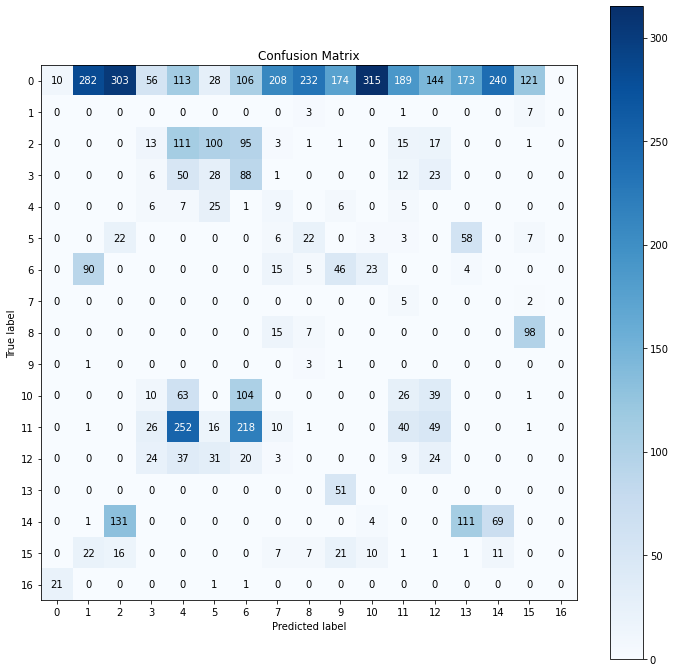

In [ ]:
try:
  import scikitplot as skplt
except ImportError:
  !pip install -q scikit-plot

  
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(12,12));

In [ ]:
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler().fit(X_train) 
# scaler = MinMaxScaler().fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

kmeans = KMeans(n_clusters=16)
kmeans.fit(X_train)
y_pred = kmeans.predict(X_test)

print('Accuracy: {}%'.format(accuracy_score(y_test, y_pred)))
print('Classification report:\n',classification_report(y_test,y_pred, zero_division=0))

Accuracy: 0.06657789613848203%
Classification report:
               precision    recall  f1-score   support

           0       0.68      0.06      0.11      2694
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00       357
           3       0.00      0.00      0.00       208
           4       0.04      0.15      0.06        59
           5       0.00      0.00      0.00       121
           6       0.21      0.60      0.31       183
           7       0.00      0.00      0.00         7
           8       0.14      0.33      0.19       120
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00       243
          11       0.00      0.00      0.00       614
          12       0.17      0.19      0.18       148
          13       0.00      0.00      0.00        51
          14       0.00      0.00      0.00       316
          15       0.01      0.01      0.01        97
          16       0.00   

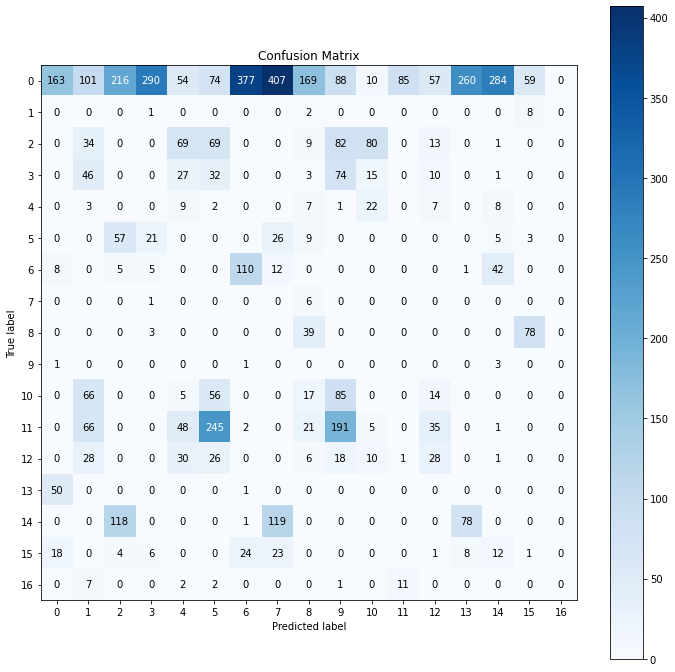

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(12,12));

### References

https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning

https://learn.microsoft.com/en-us/training/modules/train-evaluate-deep-learn-models/

https://github.com/MicrosoftDocs/ml-basics/blob/master/05a%20-%20Deep%20Neural%20Networks%20(PyTorch).ipynb

https://github.com/MicrosoftDocs/ml-basics/blob/master/05a%20-%20Deep%20Neural%20Networks%20(TensorFlow).ipynb

https://github.com/MicrosoftDocs/ml-basics/blob/master/05b%20-%20Convolutional%20Neural%20Networks%20(PyTorch).ipynb

https://github.com/MicrosoftDocs/ml-basics/blob/master/05b%20-%20Convolutional%20Neural%20Networks%20(Tensorflow).ipynb

https://www.bigdataheaven.com/wp-content/uploads/2019/02/AI-Neural-Networks.-22.pdf

https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning

https://medium.com/the-test-sheep/testing-a-neural-network-solution-2a0c0b6977dd

https://github.com/syamkakarla98/Hyperspectral_Image_Analysis_Simplified/tree/master/Notebooks

https://github.com/HasibAlMuzdadid/Hyperspectral-Image-Classification

https://github.com/syamkakarla98/Dimensionality-reduction-and-classification-on-Hyperspectral-Images-Using-Python/blob/master/indian_pines_pca.py

https://github.com/HasibAlMuzdadid/Hyperspectral-Image-Classification/blob/main/pca%2Bsvm%5Bindian%20pines%5D.ipynb

https://github.com/kk289/ML-K-Means_Clustering_and_PCA-MATLAB

https://arxiv.org/pdf/2104.04496.pdf

https://arxiv.org/pdf/2104.00341v1.pdf

https://arxiv.org/ftp/arxiv/papers/2202/2202.06458.pdf

https://arxiv.org/pdf/1902.06701v3.pdf

https://arxiv.org/pdf/2206.02327v2.pdf

https://arxiv.org/pdf/2105.14327v1.pdf

https://ieeexplore.ieee.org/document/9306920

https://arxiv.org/pdf/1903.06258v2.pdf

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9325094

http://dx.doi.org/10.1109/tcsvt.2022.3218284

https://arxiv.org/pdf/1612.00144v2.pdf

https://arxiv.org/pdf/1705.00727v2.pdf

https://arxiv.org/pdf/1810.12563v1.pdf




